In [3]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

In [4]:
def load_images(im_base_path):
    bgr_image = cv.imread(f'{im_base_path}_crop.png', cv.IMREAD_UNCHANGED)
    depth_image = cv.imread(f'{im_base_path}_depthcrop.png', cv.IMREAD_UNCHANGED)
    mask_image = cv.imread(f'{im_base_path}_maskcrop.png', cv.IMREAD_UNCHANGED)

    return bgr_image, depth_image, mask_image

In [5]:
im_base_path = '/Users/mimi/Desktop/rgbd-dataset/apple/apple_1/apple_1_1_1'

bgr_image, depth_image, mask_image = load_images(im_base_path)

In [6]:
bgr_image.shape

(84, 78, 3)

In [7]:
depth_image.shape

(84, 78)

In [8]:
# single-channel uint16 depth image. Each pixel gives the depth in millimeters, with 0 denoting missing depthz
depth_image

array([[1126, 1126, 1126, ..., 1126, 1126, 1126],
       [1130, 1130, 1126, ..., 1130, 1130, 1130],
       [1130, 1130, 1130, ..., 1130, 1130, 1130],
       ...,
       [ 727,  725,  725, ...,  722,  722,  722],
       [ 723,  723,  723, ...,  719,  719,  719],
       [ 722,  720,  720, ...,  716,  717,  717]], dtype=uint16)

In [9]:
# convert from openCV's BGR form to RGB (to plot in matplotlib and use in pretrained models)
rgb_image = cv.cvtColor(bgr_image, cv.COLOR_BGR2RGB)

In [10]:
def plot_rgb_depth(rgb_im, depth_im, mask_image=None):
    '''plots rgb, depth, and mask images next to each other'''
    
    if mask_image is None:
        fig, (rgb_ax, depth_ax) = plt.subplots(nrows=1, ncols=2)

        rgb_ax.imshow(rgb_im);
        rgb_ax.set_title('RGB Image')

        depth_ax.imshow(depth_im, cmap='binary');
        depth_ax.set_title('Depth Image')
    else:
        fig, (rgb_ax, depth_ax, mask_ax) = plt.subplots(nrows=1, ncols=3)

        rgb_ax.imshow(rgb_im);
        rgb_ax.set_title('RGB Image')

        depth_ax.imshow(depth_im, cmap='binary');
        depth_ax.set_title('Depth Image')       

        mask_ax.imshow(mask_image, cmap='binary');
        mask_ax.set_title('Binary mask')       
         

    return fig
    

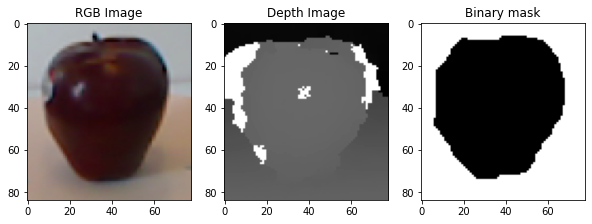

In [11]:
fig = plot_rgb_depth(rgb_image, depth_image, mask_image=mask_image);
fig.set_size_inches([10, 5])

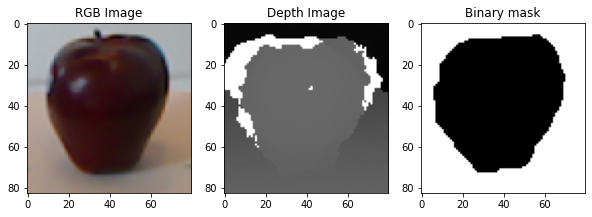

In [12]:
# look at other images of this object at different angles
i = 5
path = '/Users/mimi/Desktop/rgbd-dataset/apple/apple_1/apple_1_1_'

im_base_path_i = f'{path}{i}'
bgr_image_i, depth_image_i, mask_image_i = load_images(im_base_path_i)
rgb_image_i = cv.cvtColor(bgr_image_i, cv.COLOR_BGR2RGB)

fig = plot_rgb_depth(rgb_image_i, depth_image_i, mask_image_i)
fig.set_size_inches([10,5])

In [13]:
np.shape(rgb_image_i), np.shape(rgb_image) # different crops!

((83, 80, 3), (84, 78, 3))

# Trying Pretrained Models

In [15]:
import tensorflow as tf
import tensorflow_hub as hub

## IMAGENET

In [16]:
# load the model's labels ()
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

16384/10484 [==============================================] - 0s 0us/step


## mobilenet_v2

In [17]:
mobilenet_url ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4" 

In [18]:
IMAGE_SHAPE = (224, 224)

mobilenet_model = tf.keras.Sequential([
    hub.KerasLayer(mobilenet_url, input_shape=IMAGE_SHAPE+(3,))
])

In [19]:
mobilenet_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              3540265   
Total params: 3,540,265
Trainable params: 0
Non-trainable params: 3,540,265
_________________________________________________________________


In [20]:
rgb_im_resized = cv.resize(rgb_image, (224, 224)) / 255
rgb_im_i_resized = cv.resize(rgb_image_i, (224, 224)) / 255

In [43]:
rgb_im_resized.shape

(224, 224, 3)

In [45]:
rgb_image.shape

(84, 78, 3)

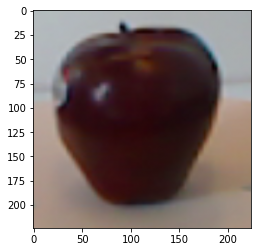

In [21]:
plt.imshow(rgb_im_resized)

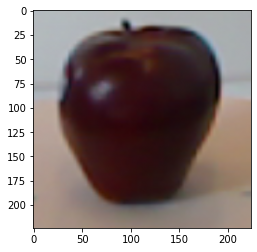

In [22]:
plt.imshow(rgb_im_i_resized)

In [25]:
pred = mobilenet_model(rgb_im_resized[np.newaxis, ...])
pred_i = mobilenet_model(rgb_im_i_resized[np.newaxis, ...])

In [26]:
pred.shape

TensorShape([1, 1001])

In [27]:
predicted_class = np.argmax(pred[0], axis=-1)
predicted_class_i = np.argmax(pred_i[0], axis=-1)
predicted_class, predicted_class_i

(991, 991)

In [28]:
pred # prediction logits for each class

<tf.Tensor: shape=(1, 1001), dtype=float32, numpy=
array([[ 0.26325038,  0.09553715, -0.1835789 , ...,  0.01054978,
        -0.9264143 , -2.3159606 ]], dtype=float32)>

In [29]:
pred[0][predicted_class] # this gives us an idea of the model's certainty that it's the class it predicted

<tf.Tensor: shape=(), dtype=float32, numpy=7.084388>

In [30]:
imagenet_labels[predicted_class] # not bad...

'buckeye'

## ResNet

In [34]:
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/classification/4"

In [35]:
resnet_model = tf.keras.Sequential([
    hub.KerasLayer(resnet_url)
])
resnet_model.build([None, 224, 224, 3])

In [36]:
resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1001)              25615849  
Total params: 25,615,849
Trainable params: 0
Non-trainable params: 25,615,849
_________________________________________________________________


In [37]:
pred = resnet_model(rgb_im_resized[np.newaxis, ...])
pred_i = resnet_model(rgb_im_i_resized[np.newaxis, ...])

In [38]:
predicted_class = np.argmax(pred[0], axis=-1)
predicted_class_i = np.argmax(pred_i[0], axis=-1)
predicted_class, predicted_class_i

(949, 949)

In [39]:
imagenet_labels[predicted_class] # pretty good!

'Granny Smith'

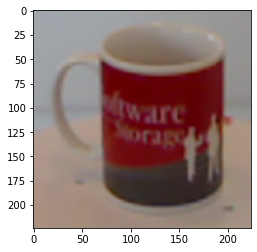

In [42]:
test_im = '/Users/mimi/Desktop/rgbd-dataset/coffee_mug/coffee_mug_1/coffee_mug_1_1_159_crop.png'
test_im = cv.imread(test_im, cv.IMREAD_UNCHANGED)
test_im = cv.cvtColor(test_im, cv.COLOR_BGR2RGB)
test_im_resized = cv.resize(test_im, (224, 224)) / 255

plt.imshow(test_im_resized)

In [30]:
pred = resnet_model(test_im_resized[np.newaxis, ...])
predicted_class = np.argmax(pred[0], axis=-1)
imagenet_labels[predicted_class] # got it right again :)

'coffee mug'